In [2]:
#! pip install sat-search

In [1]:
import folium
import os, shutil
from glob import glob
%matplotlib inline  
import json
import satsearch
import numpy as np
import geopandas as gpd


In [4]:
tr_sentinel_tiles=gpd.read_file('../boundries/sentinel_tr_tiles.shp')

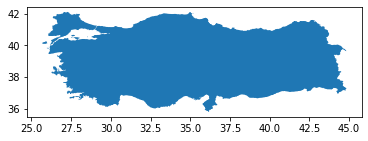

In [5]:
tr_sentinel_tiles.plot()

In [6]:
#data from http://geojson.io 
data={
  "type": "FeatureCollection",
  "features": [
    {
      "type": "Feature",
      "properties": {},
      "geometry": {
        "type": "Polygon",
        "coordinates": [
          [
            [
              38.54827880859375,
              36.90378362619561
            ],
            [
              40.0067138671875,
              36.90378362619561
            ],
            [
              40.0067138671875,
              37.89219554724437
            ],
            [
              38.54827880859375,
              37.89219554724437
            ],
            [
              38.54827880859375,
              36.90378362619561
            ]
          ]
        ]
      }
    }
  ]
}

In [7]:
datajson=json.dumps(data)

In [8]:
target_area=gpd.read_file(datajson)


In [9]:
#intersect target area with landsat path-row 
tiles_intersection = tr_sentinel_tiles[tr_sentinel_tiles.intersects(target_area.geometry[0])]
tiles_intersection.reset_index(drop=True,inplace=True)

In [10]:
# Get the center of the map
xy = np.asarray(target_area.centroid[0].xy).squeeze()
center = list(xy[::-1])
zoom = 7
# Create the most basic OSM folium map
m = folium.Map(location=center, zoom_start=zoom)
# Add the bounds GeoDataFrame in red
m.add_child(folium.GeoJson(target_area.__geo_interface__, name='Area of Study', 
                           style_function=lambda x: {'color': 'red', 'alpha': 0}))
m

In [11]:
len(tiles_intersection)

6

In [12]:
# Iterate through each Polygon of paths and rows intersecting the area
for i, row in tiles_intersection.iterrows():
    # Create a string for the name containing the path and row of this Polygon
    name = f'ID:{row[0]}' 
    # Create the folium geometry of this Polygon 
    g = folium.GeoJson(row.geometry.__geo_interface__, name=name)
    # Add a folium Popup object with the name string
    g.add_child(folium.Popup(name))
    # Add the object to the map
    g.add_to(m)

    
    
    
m

In [13]:
# All tile numbes in intersect dataframe
# You can select your tile which you want to drop from list
tiles_list = sorted(tiles_intersection['name'].unique().tolist())
tiles_list

['37SDA', '37SDB', '37SDC', '37SEA', '37SEB', '37SEC']

In [14]:
def drop_tile(df,drop_list):
    for t in drop_list:
        df.drop(df[df.name==t].index, inplace=True)

In [15]:
drop_list=['']

In [16]:
drop_tile(tiles_intersection,drop_list)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [17]:
tiles_intersection

,name,folders,descriptio,altitude,alt_mode,time_begin,time_end,time_when,GID_0,NAME_0,geometry
0,37SDA,Features,TILE PROPERTIES<br><table border=0 cellpadding...,0.0,None,None,None,None,TUR,Turkey,"POLYGON Z ((37.8750647374 37.0412497841 0, 39...."
1,37SDB,Features,TILE PROPERTIES<br><table border=0 cellpadding...,0.0,None,None,None,None,TUR,Turkey,"POLYGON Z ((37.8614709212 37.9420809161 0, 39...."
2,37SDC,Features,TILE PROPERTIES<br><table border=0 cellpadding...,0.0,None,None,None,None,TUR,Turkey,"POLYGON Z ((37.8472486493 38.843310058 0, 39.1..."
3,37SEA,Features,TILE PROPERTIES<br><table border=0 cellpadding...,0.0,None,None,None,None,TUR,Turkey,"POLYGON Z ((38.9997750832 37.0465830501 0, 40...."
4,37SEB,Features,TILE PROPERTIES<br><table border=0 cellpadding...,0.0,None,None,None,None,TUR,Turkey,"POLYGON Z ((38.9997723645 37.9475895716 0, 40...."
5,37SEC,Features,TILE PROPERTIES<br><table border=0 cellpadding...,0.0,None,None,None,None,TUR,Turkey,"POLYGON Z ((38.9997695202 38.8489984834 0, 40...."


Sentinel-2 Band Information

'B01': {'title': 'Band 1 (coastal) 60m',}
'B02': {'title': 'Band 2 (blue) 10m',}
'B03': {'title': 'Band 3 (green) 10m',}
'B04': {'title': 'Band 4 (red) 10m'  ,}
'B05': {'title': 'Band 5 20m',}
'B06': {'title': 'Band 6 20m',}
'B07': {'title': 'Band 7 20m',}
'B08': {'title': 'Band 8 (nir) 10m',}
'B8A': {'title': 'Band 8A 20m',}
'B09': {'title': 'Band 9  60m',}
'B11': {'title': 'Band 11 (swir16) 20m',}
'B12': {'title': 'Band 12 (swir22) 20m' ,}
'AOT': {'title': 'Aerosol Optical Thickness (AOT) 60m',}
'WVP': {'title': 'Water Vapour (WVP) 10m',}
'SCL': {'title': 'Scene Classification Map (SCL) 20m'}

You should give band list to function 

band_list=['B03','B04','B05']


In [18]:
def find_sentinel(target_aoi,date,tiles_list,max_cloud,band_list):
    URL='https://earth-search.aws.element84.com/v0'
    results = satsearch.Search.search(url=URL,
                                  collections=['sentinel-s2-l2a-cogs'], # note collection='sentinel-s2-l2a-cogs' doesn't work
                                  datetime=date,
                                  bbox=target_aoi,
                                  query={'eo:cloud_cover': {'lt':max_cloud}}, )
    result_list=[]
    for t in tiles_list:
        # query keywords
        tile_number=int(t[0:2])
        lat_band=t[2]
        grid_sq=t[3:]
        items = results.items()
        items.filter('sentinel:utm_zone',[tile_number,])
        items.filter('sentinel:latitude_band',[lat_band])
        items.filter('sentinel:grid_square', [grid_sq])
        selected_item=sorted(items.properties('eo:cloud_cover'))[0]
        #select best image
        items.filter('eo:cloud_cover', [selected_item])
        #print(items.summary(['date', 'id', 'eo:cloud_cover']))
        #items.__getitem__(0)
        tile_dict={'tile_name':t}
        bands_dict={}
        for b in band_list:
            band_url=items.__getitem__(0).assets[b]['href']
            bands_dict[b]=band_url
            
        img_name=items.__getitem__(0).properties['sentinel:product_id']
        imgs_dict={'image_name':img_name,'bands':bands_dict}
        tile_dict[f'tile_images']=imgs_dict        
        result_list.append(tile_dict)
    
    return result_list
            

In [19]:
tiles_list = sorted(tiles_intersection['name'].unique().tolist())
tiles_list

['37SDA', '37SDB', '37SDC', '37SEA', '37SEB', '37SEC']

In [20]:
#bbox = [32.48, -3.24, 36.58, -3.14] # (min lon, min lat, max lon, max lat)
boundry=list(target_area.geometry.bounds.values[0]) #boundry from your AOI
bbox=[boundry[0],boundry[1],boundry[2],boundry[3]] #(min lon, min lat, max lon, max lat)
dates = '2020-07-01/2020-07-12'
band_list=['B03','B04','B05']
cloud_percentage=20

In [24]:
%%time
image_list=find_sentinel(target_aoi=bbox,
                         date=dates,
                         tiles_list=tiles_list[0:3],
                         max_cloud=cloud_percentage,
                         band_list=band_list)


CPU times: user 260 ms, sys: 33.2 ms, total: 293 ms
Wall time: 9.49 s


In [25]:
image_list

[{'tile_name': '37SDA',
  'tile_images': {'image_name': 'S2A_MSIL2A_20200711T080611_N0214_R078_T37SDA_20200711T112854',
   'bands': {'B03': 'https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/37/S/DA/2020/7/S2A_37SDA_20200711_0_L2A/B03.tif',
    'B04': 'https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/37/S/DA/2020/7/S2A_37SDA_20200711_0_L2A/B04.tif',
    'B05': 'https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/37/S/DA/2020/7/S2A_37SDA_20200711_0_L2A/B05.tif'}}},
 {'tile_name': '37SDB',
  'tile_images': {'image_name': 'S2B_MSIL2A_20200706T080609_N0214_R078_T37SDB_20200706T113231',
   'bands': {'B03': 'https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/37/S/DB/2020/7/S2B_37SDB_20200706_1_L2A/B03.tif',
    'B04': 'https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/37/S/DB/2020/7/S2B_37SDB_20200706_1_L2A/B04.tif',
    'B05': 'https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-co

In [158]:
# find more than 1 image for target Sentinel tile
def find_sentinel_stack(target_aoi,date,tiles_list,max_cloud,band_list,numberOfImages=3):
    URL='https://earth-search.aws.element84.com/v0'
    results = satsearch.Search.search(url=URL,
                                  collections=['sentinel-s2-l2a-cogs'], # note collection='sentinel-s2-l2a-cogs' doesn't work
                                  datetime=date,
                                  bbox=target_aoi,
                                  query={'eo:cloud_cover': {'lt':max_cloud}}, )
    result_list=[]
    for t in tiles_list:
        tile_number=int(t[0:2])
        lat_band=t[2]
        grid_sq=t[3:]
        items = results.items()
        items.filter('sentinel:utm_zone',[tile_number,])
        items.filter('sentinel:latitude_band',[lat_band])
        items.filter('sentinel:grid_square', [grid_sq])
        selected_items=sorted(items.properties('eo:cloud_cover'))
        items.filter('eo:cloud_cover',selected_items[0:numberOfImages])
        #print(items.summary(['date', 'id', 'eo:cloud_cover']))
        #items.__getitem__(0)
        tile_dict={'tile_name':t}
        bands_dict={}
        for number in range(numberOfImages):
            for b in band_list:           
                band_url=items.__getitem__(number).assets[b]['href']
                bands_dict[b]=band_url
                
            img_name=items.__getitem__(number).properties['sentinel:product_id']
            imgs_dict={'image_name':img_name,'bands':bands_dict}
            tile_dict[f'tile_images_{str(number)}']=imgs_dict
        
        result_list.append(tile_dict)
    
    return result_list

In [159]:
items

['37SDA', '37SDB', '37SDC', '37SEA', '37SEB', '37SEC']

In [160]:
#bbox = [32.48, -3.24, 36.58, -3.14] # (min lon, min lat, max lon, max lat)
boundry=list(target_area.geometry.bounds.values[0]) #boundry from your AOI
bbox=[boundry[0],boundry[1],boundry[2],boundry[3]] #(min lon, min lat, max lon, max lat)
dates = '2020-07-01/2020-07-12'
band_list=['B03','B04','B05']
cloud_percentage=20

In [161]:
%%time
image_list=find_sentinel_stack(target_aoi=bbox,
                         date=dates,
                         tiles_list=tiles_list[0:3],
                         max_cloud=cloud_percentage,
                         band_list=band_list)


CPU times: user 268 ms, sys: 23.1 ms, total: 291 ms
Wall time: 10.4 s


In [162]:
image_list

[{'tile_name': '37SDA',
  'tile_images_0': {'image_name': 'S2A_MSIL2A_20200711T080611_N0214_R078_T37SDA_20200711T112854',
   'bands': {'B03': 'https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/37/S/DA/2020/7/S2B_37SDA_20200706_0_L2A/B03.tif',
    'B04': 'https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/37/S/DA/2020/7/S2B_37SDA_20200706_0_L2A/B04.tif',
    'B05': 'https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/37/S/DA/2020/7/S2B_37SDA_20200706_0_L2A/B05.tif'}},
  'tile_images_1': {'image_name': 'S2B_MSIL2A_20200706T080609_N0214_R078_T37SDA_20200706T113231',
   'bands': {'B03': 'https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/37/S/DA/2020/7/S2B_37SDA_20200706_0_L2A/B03.tif',
    'B04': 'https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/37/S/DA/2020/7/S2B_37SDA_20200706_0_L2A/B04.tif',
    'B05': 'https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/37/S/DA/2020/7/S2B

In [163]:
image_list[0]

{'tile_name': '37SDA',
 'tile_images_0': {'image_name': 'S2A_MSIL2A_20200711T080611_N0214_R078_T37SDA_20200711T112854',
  'bands': {'B03': 'https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/37/S/DA/2020/7/S2B_37SDA_20200706_0_L2A/B03.tif',
   'B04': 'https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/37/S/DA/2020/7/S2B_37SDA_20200706_0_L2A/B04.tif',
   'B05': 'https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/37/S/DA/2020/7/S2B_37SDA_20200706_0_L2A/B05.tif'}},
 'tile_images_1': {'image_name': 'S2B_MSIL2A_20200706T080609_N0214_R078_T37SDA_20200706T113231',
  'bands': {'B03': 'https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/37/S/DA/2020/7/S2B_37SDA_20200706_0_L2A/B03.tif',
   'B04': 'https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/37/S/DA/2020/7/S2B_37SDA_20200706_0_L2A/B04.tif',
   'B05': 'https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/37/S/DA/2020/7/S2B_37SDA_20